In [1]:
import cv2
import mediapipe as mp
import urllib.request as urlreq
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle, Ellipse, Rectangle
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import json
import pandas as pd

#from rembg import remove

from config import *
from cropping import *
from landmarks_utils import *
from preprocessing import *
from face_landmarking_model import *
from face_dataset import *
from glob import glob

In [2]:
groups_results = pd.read_json('training_results_means.json', orient='index')
groups_results.columns = ['result']



In [3]:

groups = [os.path.basename(os.path.normpath(path_string)) for path_string in glob("./AI_Morphometrics/*/", recursive = False)]


In [4]:
rows = []
with open('./preprocessed_data/path_list.txt', 'r') as file:
    for line in file:
        rows.append(line.strip())

list_df = pd.DataFrame({'text': rows})

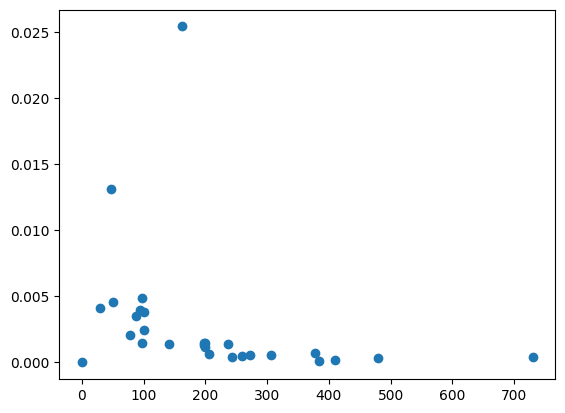

In [5]:
counts = {}
for group in groups:
    counts[group] = len(list_df[list_df['text'].str.contains(group)])
counts
compare = pd.concat([groups_results, pd.DataFrame(counts.items(), columns=['group', 'sample']).set_index('group')], axis = 1)
plt.scatter(x=compare['sample'], y=compare['result'])

In [6]:
PROJECTORS = 5
best_groups = compare.sort_values(by=['sample'])[-PROJECTORS:].index.to_list()
best_groups
compare.sort_values(by=['result']).tail(5)

,result,sample
Mauri_2020,0.004094,30
ARAB_sample,0.004583,50
ULA_foto,0.004902,98
BOSS_55,0.013122,48
SET_EyeHairDim,0.025430,162


In [7]:
class CustomSampler:
    def __init__(self, dataset):
        self.dataset = dataset

    def __iter__(self):
        return iter(torch.randperm(len(self.dataset))[:200])

    def __len__(self):
        return len(self.dataset)

In [8]:
model = FaceLandmarking(projectors=PROJECTORS).to(DEVICE)
main_dataset = FaceDataset(model)
main_dataloader = DataLoader(main_dataset, batch_size=100, shuffle=True)

ensemble_dataset = []
ensemble_dataloader = []
# ensemble_optimizer = torch.optim.Adam(params=[], lr = 0.0001)

# for projector in model.ensemble:
#     ensemble_optimizer.add_param_group({'params': model.parameters()})

print('creating datasets')
for group in tqdm(best_groups):
    simple_dataset = FaceDataset(model, subgroups=[group])
    ensemble_dataset.append(simple_dataset)
    ensemble_dataloader.append(DataLoader(simple_dataset, batch_size=50, sampler=CustomSampler(simple_dataset)))

ensemble_optimizer = torch.optim.Adam(model.ensemble.parameters(), lr = 0.0001)
optimizer2 = torch.optim.Adam(model.cnn_focusing.parameters(), lr = 0.0001)
optimizer3 = torch.optim.Adam(model.ffn.parameters(), lr = 0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(ensemble_optimizer, step_size=1, gamma=0.98)

epochs = 100
PRETRAINING = True 
pretrain_epochs = 500
optimizers = [ensemble_optimizer]
TRAIN_PHASE = 0

cache = {}
#cache["no_scheduler"] = []
cache["scheduler"] = []

print('start training')
for epoch in range(epochs):

    if epoch == pretrain_epochs:
        PRETRAINING = False
        optimizers = [optimizer2]
        TRAIN_PHASE += 1
        print('Freezing raw_projection, training CNN_focusing.')

    if epoch == 600:
        optimizers = [optimizer3]
        TRAIN_PHASE += 1
        print('Freezing CNN_focusing, training top FFN.')

    if epoch == 800:
        optimizers = [ensemble_optimizer, optimizer2, optimizer3]

    main_dataset.pretraining = PRETRAINING
    model.train_phase = TRAIN_PHASE

    
    if PRETRAINING:
        ensemble_inputs = []
        ensemble_targets = []
        for data_loader in ensemble_dataloader:
            batch = next(iter(data_loader))
            inputs, targets, _ = batch
            ensemble_inputs.append(inputs)
            ensemble_targets.append(targets)
        
        for optimizer in optimizers:
            optimizer.zero_grad()
        
        _, final_loss, raw_loss = model(
            ensemble_inputs,
            targets = ensemble_targets,
            multicrop = None,
        )
        
        cache["scheduler"].append(final_loss.item())
        final_loss.backward()

        for optimizer in optimizers:
            optimizer.step()
        
        scheduler.step()
        
        if epoch < epochs-5:
            print(f'Epoch: {epoch}, current loss: {final_loss}', end="\r")
        else:
            batch = next(iter(main_dataloader))
            inputs, targets, _ = batch
               
            _, total_loss, raw_loss = model(
                ensemble_inputs,
                targets = ensemble_targets,
                multicrop = None,
            )

            print(f'\n Epoch: {epoch}, complete sataset loss: {total_loss}', end = "")
            
       
    else:
        for iteration, batch in enumerate(main_dataloader):
            for optimizer in optimizers:
                optimizer.zero_grad()

            inputs, targets, multicrop = batch
            
            _, final_loss, raw_loss = model(
                inputs,
                targets = targets,
                multicrop = multicrop,
            )

            cache["scheduler"].append(final_loss.item())
            final_loss.backward()

            for optimizer in optimizers:
                optimizer.step()
            

            if iteration == 0:

                if epoch <= pretrain_epochs and epoch % 20 == 0:
                    print(f'Epoch: {epoch}, current loss: {final_loss}.')

                if epoch > pretrain_epochs and epoch % 2 == 0:
                    print(f'Epoch: {epoch}, iteration: {iteration}, final loss: {final_loss}, raw loss: {raw_loss}.')
        
    

creating datasets


100%|██████████| 5/5 [00:01<00:00,  4.80it/s]


start training
Epoch: 94, current loss: 0.0006003372836858034
 Epoch: 95, complete sataset loss: 0.0009836407843977213
 Epoch: 96, complete sataset loss: 0.0008706672815605998
 Epoch: 97, complete sataset loss: 0.0009684655233286321
 Epoch: 98, complete sataset loss: 0.00087001733481884
 Epoch: 99, complete sataset loss: 0.0007210419280454516

In [ ]:
 8
 Epoch: 95, complete sataset loss: 0.0010883823269978166
 Epoch: 96, complete sataset loss: 0.000980888493359089
 Epoch: 97, complete sataset loss: 0.0009879092685878277
 Epoch: 98, complete sataset loss: 0.0011010838206857443
 Epoch: 99, complete sataset loss: 0.0011781544890254736
 
 5
 Epoch: 95, complete sataset loss: 0.0007188928429968655
 Epoch: 96, complete sataset loss: 0.0006777612143196166
 Epoch: 97, complete sataset loss: 0.0006233208696357906
 Epoch: 98, complete sataset loss: 0.0006583758513443172
 Epoch: 99, complete sataset loss: 0.0007602511323057115
 
 10
  Epoch: 95, complete sataset loss: 0.001322360010817647
 Epoch: 96, complete sataset loss: 0.0015559622552245855
 Epoch: 97, complete sataset loss: 0.0013130202423781157
 Epoch: 98, complete sataset loss: 0.0014194237301126122
 Epoch: 99, complete sataset loss: 0.0014356100000441074
  
 6
  Epoch: 95, complete sataset loss: 0.0009560771286487579
 Epoch: 96, complete sataset loss: 0.0009323054109700024
 Epoch: 97, complete sataset loss: 0.0007936069159768522
 Epoch: 98, complete sataset loss: 0.000828711548820138
 Epoch: 99, complete sataset loss: 0.000695841561537236
 
 3
  Epoch: 95, complete sataset loss: 0.0006919826264493167
 Epoch: 96, complete sataset loss: 0.0005339005729183555
 Epoch: 97, complete sataset loss: 0.00038532333564944565
 Epoch: 98, complete sataset loss: 0.0004209089674986899
 Epoch: 99, complete sataset loss: 0.0005866805440746248
 

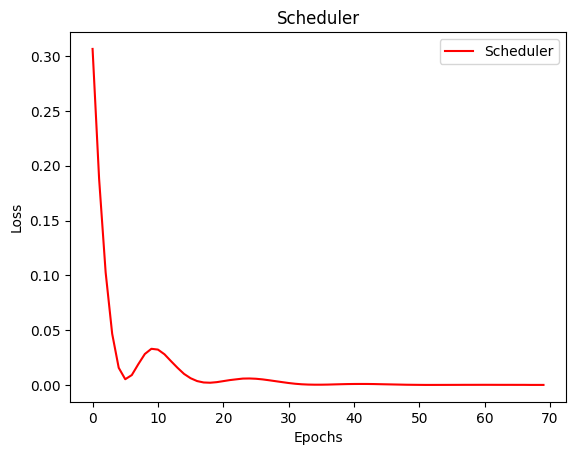

In [89]:
scope = 70
fig, ax = plt.subplots()


# Plot the second scatter plot with blue dots
# ax.plot(range(scope), cache["no_scheduler"][:scope], linestyle='--',c='blue', label='No scheduler')

# Plot the first scatter plot with red dots
ax.plot(range(scope), cache["scheduler"][:scope], linestyle='-', c='red', label='Scheduler')



# Add labels and a legend
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.set_title('Scheduler')
ax.legend()

# Show the plot
plt.show()

tensor([1707])


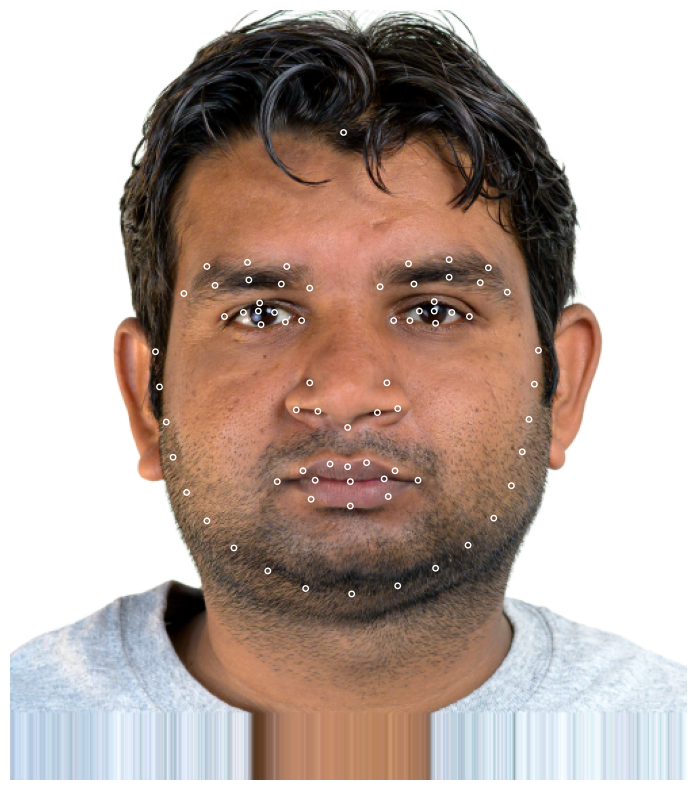

In [12]:
idx = torch.randint(main_dataset.__len__(),(1,))
print(idx)
batch = main_dataset.__getitem__(idx)
inputs, targets, multicrop = batch
img_path = main_dataset.path_list[idx]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
landmarks, _, image = model.predict(image, face_detail=True)
display_landmarks(landmarks.reshape(-1,2), image, pixel_scale=True, origin='upper_left')
# display_landmarks(inputs.reshape(-1,2), image, pixel_scale=False, origin='upper_left')
# display_landmarks(targets.reshape(-1,2), image, pixel_scale=False, origin='upper_left')

In [21]:
group = sample_groups[np.random.randint(len(sample_groups))]
for file in os.listdir(group):
    if '.TPS' in file or '.tps' in file:
        tps = readtps(group + '/' + file, group)
        
idx = np.random.randint(len(tps['im']))
true_l= tps['coords'][:, :, idx]
img_path = group + '/' + tps['im'][idx]
image = cv2.imread(img_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
subimage, xmin, ymin, xmax, ymax = crop_face_only(image)
subimage = standard_face_size(subimage)
plt.imshow(subimage)

NameError: name 'sample_groups' is not defined

In [ ]:
@torch.no_grad()
def show_some_results(group = None, idx = None):
    if group is None:
        group = sample_groups[np.random.randint(len(sample_groups))]
    
    for file in os.listdir(group):
        if '.TPS' in file or '.tps' in file:
             tps = readtps(group + '/' + file, group)
        
    if idx is None:
        idx = np.random.randint(len(tps['im']))
        
    true_landmarks = tps['coords'][:, :, idx]
    img_path = group + '/' + tps['im'][idx]
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    face_detail = crop_face_only(image)
    if face_detail:
        subimage, xmin, ymin, xmax, ymax = face_detail
    
    # Both model use float(0,1) for x and y axis
    input_landmarks = MediaPipe_model(subimage)
    #input_landmarks = np.concatenate((LBF_model(image), MediaPipe_model(image)), axis = 0)

    #true_landmarks = np.subtract(true_landmarks, (xmin, image.shape[0] - ymax))
    #true_landmarks = np.divide(true_landmarks, (subimage.shape[1], subimage.shape[0]))
     
    # Převod původních pixelových na float, flip y-axis
    true_landmarks = torch.from_numpy(1 - np.divide(true_landmarks, (image.shape[1], image.shape[0]))).to(device)

    # batch_dim = 0
    input_landmarks = torch.from_numpy(input_landmarks.reshape(1,-1)).float().to(device)
    raw_landmarks, _ = model.raw_projection(input_landmarks, None)

    multicrop = make_landmark_crops(raw_landmarks, subimage)
    
    #předělat a použít prediction method
    projection, _, _ = model(input_landmarks, true_landmarks.reshape(1,-1), multicrop = multicrop[None,:,:,:], image_shape = subimage.shape)
    projection = projection.cpu().detach().numpy().reshape(true_landmarks.shape)
    
    # tady připočíst xmin a ten druhý pól image_shape - ymax
    return projection, image, true_landmarks, raw_landmarks

In [ ]:
model.eval()
idx = -1

In [ ]:
idx += 10

In [ ]:
proj, im, y, raw = show_some_results(idx)

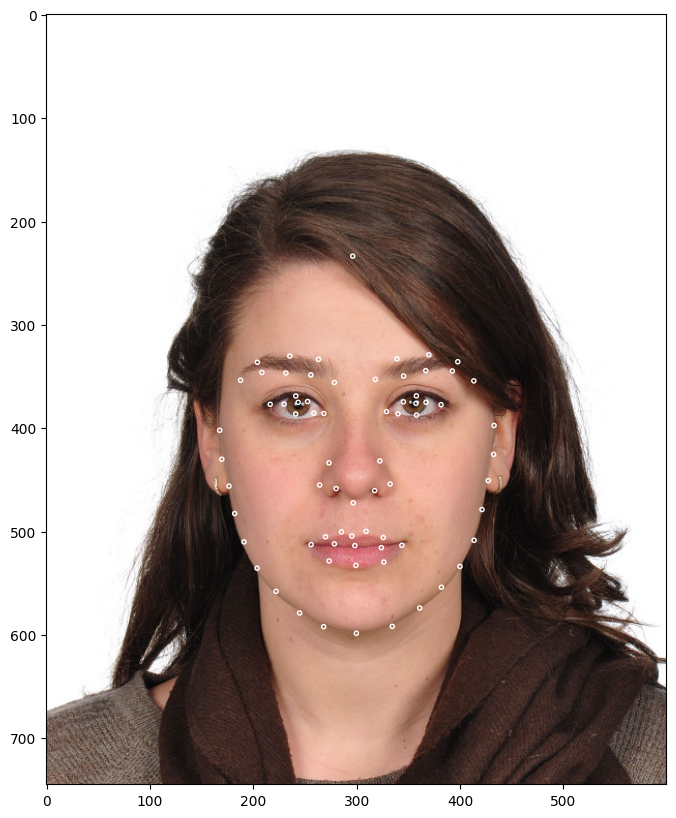

In [ ]:
display_landmarks(proj.reshape(-1,2), im, pixel_scale = False, origin = 'upper_left')